In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output


In [3]:
# This function works with both dbtable and the catalog header name on EDD
def get_catal(catal_string, infoFile="../bar_files/catalogs_info.dat", bars_folder='../bar_files/'):
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.", verbose=True)

    with open(infoFile, "r") as f:
        lines = f.readlines()


        try:
            for i, line in enumerate(lines):
                if catal_string in line:
                    
                    while not "begin" in line:
                        i-=1
                        line = lines[i]
                    while not "filename" in line:
                        i+=1
                        line=lines[i]

                    fname_string = line
                    break
        except: 
            return "", []
            
        catal_columns = []
        
        try:
            while not "column" in line:
                i+=1
                line=lines[i]
            while not 'end' in line:
                catal_columns.append(line.split("=>")[1].split("|")[0].strip())
                i+=1
                line=lines[i]
                
        except:
            print("why")
            return "", []


    catal_file_name = fname_string.split("=>")[1].strip("\n").strip("")
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/"+catal_file_name+"  "+bars_folder+"/.", verbose=True)
    
    data = pd.read_csv(bars_folder+catal_file_name, names=catal_columns, delimiter='|')
    
    for col in catal_columns:
        if col.upper()=="PGC":
            break
    
    data.rename(columns={col:col.upper()}, inplace=True)
    data = data.set_index('PGC')
    
    # taking care of empty string
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if "1PGC" in data.columns:
        data = data.rename(columns={"1PGC": "PGC1"})
    else:
        data["PGC1"] = data.index.values
    
    if "av_flag" in data.columns:
        data = data[data.av_flag==0]
    
    
    return data

In [4]:
def make_data(data, catalogs, catal_data, catal_key, catal_DM="DM", catal_eDM="eDM", delta=0, \
              cols=["Vcmb","Nest"]):
    
    if not catal_key in catalogs and not catal_key in data:
        data[catal_key] = catal_data[["PGC1", catal_DM, catal_eDM]+cols]
        data[catal_key] = data[catal_key].rename(columns={"PGC1": "PGC1_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_DM: "DM_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_eDM: "eDM_"+catal_key})
        
        for col in cols:
            data[catal_key] = data[catal_key].rename(columns={col: col+"_"+catal_key})
        
        catalogs.append(catal_key)
        
        data[catal_key]["DM_"+catal_key] += delta
        
    else:
        print("This catalog has been already imported ...")
        print("Use a different key than "+catal_key)
    
    return data, catalogs
    

In [5]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [6]:
catalogs = []

def prepare_data(df, catal_name, col_names, col2=[]):
    
    cat = catal_name
    
    if col_names is None:
        return df
    else:
        df["DM_"+cat]   = df[col_names[0]]
        df["eDM_"+cat]  = df[col_names[1]]
        df['Vcmb_'+cat] = df[col_names[2]]
        df['gSGL_'+cat] = df[col_names[3]]
        df['gSGB_'+cat] = df[col_names[4]]
       
    df["eDM_"+cat][df["DM_"+cat]==0] = np.nan
    df["DM_"+cat][df["DM_"+cat]==0] = np.nan
    df['Vcmb_'+cat][df["DM_"+cat].isna()] = np.nan
    
    columns = ["DM", "eDM", "Vcmb", "gSGL", "gSGB"]
    
    if not catal_name in catalogs:
        catalogs.append(catal_name)
    
    return df[[col+'_'+cat for col in columns]+col2]

In [7]:
catal_dbtable = "kcf4allcalgp"
data = get_catal(catal_dbtable)

df = data[["DM", "N"]].rename(columns={"N":"Nc", "DM":"DMcal"})

df.head()

,DMcal,Nc
PGC,,
35,29.73,1
143,24.91,1
218,30.73,1
388,29.65,1
591,29.51,1


In [8]:
catal_dbtable = "kcf4sniagroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SNIa', ['DM', 'eDM', 'gVcmb', 'gSGL', 'gSGB'], ["N"]).rename(columns={"N":"Nsn"})

print(len(data))

df = df.join(data, how='outer')

df.head()

945


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn
PGC,,,,,,,,
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN
143,24.91,1.0,NaN,NaN,NaN,NaN,NaN,NaN
218,30.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN
250,NaN,NaN,35.05,0.13,6894.0,316.3212,17.6719,1.0
282,NaN,NaN,36.04,0.11,10921.0,282.0792,8.9703,1.0


In [9]:
data = pd.read_csv('./allcf4fp_group_bar.221123', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'FP', ['DM_w', 'eDM', 'gVcmb', 'gSGL', 'gSGB'], ["Nfp"])

print(len(data))

df = df.join(data, how='outer')

df.head()

27696


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,Nfp
PGC,,,,,,,,,,,,,,
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.463,0.299,11521.0,251.2392,-1.4353,5.0
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.280,0.520,14051.0,288.5214,11.5692,1.0
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.950,0.500,10964.0,278.4600,8.4002,1.0
143,24.91,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
catal_dbtable = "kcf4tfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'TFR', ['DM_w', 'eDM', 'gVcmb', 'gSGL', 'gSGB'], ["Ntf"])

print(len(data))

df = df.join(data, how='outer')

df.head()

10188


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,Nfp,DM_TFR,eDM_TFR,Vcmb_TFR,gSGL_TFR,gSGB_TFR,Ntf
PGC,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,6179.0,286.4249,11.3510,1.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,11474.0,300.8070,15.3909,1.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,5354.0,287.6120,11.7030,1.0
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,4466.0,327.0996,19.7763,1.0


In [11]:
catal_dbtable = "kcf4sbfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SBFm', ['DMm_w', 'eDMm', 'gVcmb', 'gSGL', 'gSGB'], ["Nmain"]).rename(columns={"Nmain":"Nsbfo"})
data = data.dropna()
print(len(data))

df = df.join(data, how='outer')

df.head()

177


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn,DM_FP,eDM_FP,...,Vcmb_TFR,gSGL_TFR,gSGB_TFR,Ntf,DM_SBFm,eDM_SBFm,Vcmb_SBFm,gSGL_SBFm,gSGB_SBFm,Nsbfo
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6179.0,286.4249,11.3510,1.0,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11474.0,300.8070,15.3909,1.0,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5354.0,287.6120,11.7030,1.0,NaN,NaN,NaN,NaN,NaN,NaN
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4466.0,327.0996,19.7763,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
catal_dbtable = "kcf4sbfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SBFir', ['DMir_w', 'eDMir', 'gVcmb', 'gSGL', 'gSGB'], ["Nir"]).rename(columns={"Nir":"Nsbfi"})
data = data.dropna()
print(len(data))

df = df.join(data, how='outer')

df.head()

57


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn,DM_FP,eDM_FP,...,Vcmb_SBFm,gSGL_SBFm,gSGB_SBFm,Nsbfo,DM_SBFir,eDM_SBFir,Vcmb_SBFir,gSGL_SBFir,gSGB_SBFir,Nsbfi
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
catal_dbtable = "kcf4sniigroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SNII', ['DM', 'eDM', 'Vcmb', 'SGL', 'SGB'])

print(len(data))

df = df.join(data, how='outer')

df.head()

94


,DMcal,Nc,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,Nsn,DM_FP,eDM_FP,...,eDM_SBFir,Vcmb_SBFir,gSGL_SBFir,gSGB_SBFir,Nsbfi,DM_SNII,eDM_SNII,Vcmb_SNII,gSGL_SNII,gSGB_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def merge_col(df, col='Vcmb'):
    
    columns = [x for x in df.columns.values if col in x]
    df[col] = df[columns].mean(axis=1)
    
    print(columns)
    df = df.drop(columns=columns)
    
    
    return df 


for col in ["Vcmb", "gSGL", "gSGB"]:
    df = merge_col(df, col=col)



['Vcmb_SNIa', 'Vcmb_FP', 'Vcmb_TFR', 'Vcmb_SBFm', 'Vcmb_SBFir', 'Vcmb_SNII']
['gSGL_SNIa', 'gSGL_FP', 'gSGL_TFR', 'gSGL_SBFm', 'gSGL_SBFir', 'gSGL_SNII']
['gSGB_SNIa', 'gSGB_FP', 'gSGB_TFR', 'gSGB_SBFm', 'gSGB_SBFir', 'gSGB_SNII']


In [15]:
df = df.rename(columns={'gSGL':'SGL', 'gSGB':'SGB'})


df.head()

,DMcal,Nc,DM_SNIa,eDM_SNIa,Nsn,DM_FP,eDM_FP,Nfp,DM_TFR,eDM_TFR,...,eDM_SBFm,Nsbfo,DM_SBFir,eDM_SBFir,Nsbfi,DM_SNII,eDM_SNII,Vcmb,SGL,SGB
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6179.0,286.4249,11.3510
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11474.0,300.8070,15.3909
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5354.0,287.6120,11.7030
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4466.0,327.0996,19.7763


In [16]:
df = df.astype("float64")

In [17]:
catalogs

['SNIa', 'FP', 'TFR', 'SBFm', 'SBFir', 'SNII']

In [18]:
myDict = {}

myDict["SNIa"] = 0.
myDict["FP"] = 0.126
myDict["TFR"] = 0.151
myDict["SBFm"] = 0.090
myDict["SBFir"] = 0.087
myDict["SNII"] = -0.095


for cat in catalogs:
    df['DM_'+cat] += myDict[cat]
    df['w_'+cat] = (1.-0)/df['eDM_'+cat]**2
    df['w_'+cat] = df['w_'+cat].apply(lambda x: x if x!=0 else np.nan)
    df['e_'+cat] = (1.-0)*df['eDM_'+cat]
    df['e_'+cat] = df['e_'+cat].apply(lambda x: x if x!=0 else np.nan)
    df['xw_'+cat] = (df['DM_'+cat])*df['w_'+cat]

sw = ['w_'+cat for cat in catalogs]
ee = ['e_'+cat for cat in catalogs]
sx = ['xw_'+cat for cat in catalogs]

Err2 = 1./df[sw].sum(axis=1)

df["eDM_av"] = np.sqrt(Err2)
df["DM_av"]  = df[sx].sum(axis=1)*Err2    

In [19]:
for cat in catalogs:
    edm = 'eDM_'+cat
    dm = 'DM_'+cat
    
    ## don't perform the adjsutments on the individual cataloged distances
    df['DM_'+cat] -= myDict[cat]
    
    print(dm, edm)
    
    df[edm] = df.apply(lambda x: x[edm] if x[dm]!=0 else np.nan, axis=1)
    df[dm] = df.apply(lambda x: x[dm] if x[dm]!=0 else np.nan, axis=1)

DM_SNIa eDM_SNIa
DM_FP eDM_FP
DM_TFR eDM_TFR
DM_SBFm eDM_SBFm
DM_SBFir eDM_SBFir
DM_SNII eDM_SNII


In [20]:
df.head()

,DMcal,Nc,DM_SNIa,eDM_SNIa,Nsn,DM_FP,eDM_FP,Nfp,DM_TFR,eDM_TFR,...,e_SBFm,xw_SBFm,w_SBFir,e_SBFir,xw_SBFir,w_SNII,e_SNII,xw_SNII,eDM_av,DM_av
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41,35.121
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38,36.221
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,34.781
35,29.73,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39,34.371


In [21]:
df["DM_zp"] = df["DM_av"] - 0.137

In [22]:
columns = ["DM_zp", "DM_av", "eDM_av", "Vcmb", "SGL", "SGB", "Nc", "DMcal"]
N_col = ["Nsn", "Nfp", "Ntf", "Nsbfo", "Nsbfi"]
for i, cat in enumerate(catalogs):
    
    if i<5:
        columns += [N_col[i]]
    columns += ['DM_'+cat]
    columns += ['eDM_'+cat]
    
    
    
df = df[columns]

df.head()

,DM_zp,DM_av,eDM_av,Vcmb,SGL,SGB,Nc,DMcal,Nsn,DM_SNIa,...,DM_TFR,eDM_TFR,Nsbfo,DM_SBFm,eDM_SBFm,Nsbfi,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,34.984,35.121,0.41,6179.0,286.4249,11.3510,NaN,NaN,NaN,NaN,...,34.97,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,36.084,36.221,0.38,11474.0,300.8070,15.3909,NaN,NaN,NaN,NaN,...,36.07,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,34.644,34.781,0.45,5354.0,287.6120,11.7030,NaN,NaN,NaN,NaN,...,34.63,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,inf,NaN,NaN,NaN,1.0,29.73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,34.234,34.371,0.39,4466.0,327.0996,19.7763,NaN,NaN,NaN,NaN,...,34.22,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cc = []
for c in df.columns[:4]:
    cc.append(c)
cc += ["RA", "DEC", "GL", "GB"]
for c in df.columns[4:]:
    cc.append(c)

cc

['DM_zp',
 'DM_av',
 'eDM_av',
 'Vcmb',
 'RA',
 'DEC',
 'GL',
 'GB',
 'SGL',
 'SGB',
 'Nc',
 'DMcal',
 'Nsn',
 'DM_SNIa',
 'eDM_SNIa',
 'Nfp',
 'DM_FP',
 'eDM_FP',
 'Ntf',
 'DM_TFR',
 'eDM_TFR',
 'Nsbfo',
 'DM_SBFm',
 'eDM_SBFm',
 'Nsbfi',
 'DM_SBFir',
 'eDM_SBFir',
 'DM_SNII',
 'eDM_SNII']

In [24]:
from kapteyn import wcs

super2celestial = wcs.Transformation("supergalactic j2000 j2000", "equatorial")
# RA, DEC = ((sgl, sgb))
super2galactic = wcs.Transformation("supergalactic j2000 j2000", "galactic")
# gl, gb = tran((sgl, sgb))

In [25]:
df["RA"] = df.apply(lambda x: super2celestial((x.SGL,x.SGB))[0], axis=1)
df["DEC"] = df.apply(lambda x: super2celestial((x.SGL,x.SGB))[1], axis=1)

df["GL"] = df.apply(lambda x: super2galactic((x.SGL,x.SGB))[0], axis=1)
df["GB"] = df.apply(lambda x: super2galactic((x.SGL,x.SGB))[1], axis=1)

df[cc].head()

,DM_zp,DM_av,eDM_av,Vcmb,RA,DEC,GL,GB,SGL,SGB,...,DM_TFR,eDM_TFR,Nsbfo,DM_SBFm,eDM_SBFm,Nsbfi,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,34.984,35.121,0.41,6179.0,0.035972,-6.373908,90.192153,-65.929994,286.4249,11.3510,...,34.97,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,36.084,36.221,0.38,11474.0,359.980535,8.184610,101.660038,-52.546451,300.8070,15.3909,...,36.07,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,34.644,34.781,0.45,5354.0,0.047049,-5.158708,91.600561,-64.865477,287.6120,11.7030,...,34.63,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,34.234,34.371,0.39,4466.0,0.155821,33.600952,110.949487,-28.085699,327.0996,19.7763,...,34.22,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df = df[cc]
df = df[df.DM_av>0]

In [27]:
df.to_csv("AllGroups_CF4_components_bar_erratum.221125.csv", sep='|')
table   = np.genfromtxt('AllGroups_CF4_components_bar_erratum.221125.csv' , delimiter='|', 
                        filling_values=-10000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["SNIa"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["PGC", "PGC1", "IDT14g", '1PGC']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int))) 
    elif key in ["Vcmb", "Vmod", "Nsn", "Nfp", "Ntf", "Nsbfi", "Nsbfo", "Nc"]:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ["SGL", "SGB", "RA", "DEC", "GL", "GB"]:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))

## to be used on EDD
myTable.write('allcf4_group_bar_erratum_221125', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [28]:
df.columns

Index(['DM_zp', 'DM_av', 'eDM_av', 'Vcmb', 'RA', 'DEC', 'GL', 'GB', 'SGL',
       'SGB', 'Nc', 'DMcal', 'Nsn', 'DM_SNIa', 'eDM_SNIa', 'Nfp', 'DM_FP',
       'eDM_FP', 'Ntf', 'DM_TFR', 'eDM_TFR', 'Nsbfo', 'DM_SBFm', 'eDM_SBFm',
       'Nsbfi', 'DM_SBFir', 'eDM_SBFir', 'DM_SNII', 'eDM_SNII'],
      dtype='object')

In [29]:
for cols in catalogs[1:]:
    df["delta_"+cols]=df["DM_FP"]-df["DM_"+cols]
    print(cols)

# ds = df.delta.dropna()
# dss = ds[np.abs(ds.values)>0.2]

# dss

FP
TFR
SBFm
SBFir
SNII


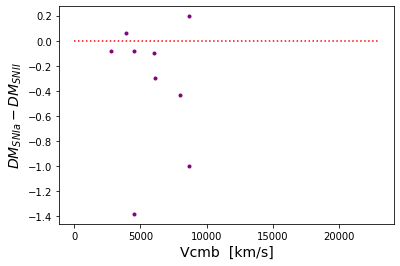

In [30]:
s = 'SNII'

plt.plot(df.Vcmb, df["delta_"+s], '.', color='purple')
plt.xlabel("Vcmb  [km/s]", fontsize=14)
plt.ylabel(r"$DM_{SNIa}-DM_{"+s+"}$", fontsize=14)

plt.plot([0,23000], [0,0], 'r:')

In [31]:
len(df)

37832

In [32]:
df.columns

Index(['DM_zp', 'DM_av', 'eDM_av', 'Vcmb', 'RA', 'DEC', 'GL', 'GB', 'SGL',
       'SGB', 'Nc', 'DMcal', 'Nsn', 'DM_SNIa', 'eDM_SNIa', 'Nfp', 'DM_FP',
       'eDM_FP', 'Ntf', 'DM_TFR', 'eDM_TFR', 'Nsbfo', 'DM_SBFm', 'eDM_SBFm',
       'Nsbfi', 'DM_SBFir', 'eDM_SBFir', 'DM_SNII', 'eDM_SNII', 'delta_FP',
       'delta_TFR', 'delta_SBFm', 'delta_SBFir', 'delta_SNII'],
      dtype='object')

In [33]:
df.head(30)

,DM_zp,DM_av,eDM_av,Vcmb,RA,DEC,GL,GB,SGL,SGB,...,Nsbfi,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII,delta_FP,delta_TFR,delta_SBFm,delta_SBFir,delta_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,34.984,35.121,0.410,6179.0,0.035972,-6.373908,90.192153,-65.929994,286.4249,11.3510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,36.084,36.221,0.380,11474.0,359.980535,8.184610,101.660038,-52.546451,300.8070,15.3909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,34.644,34.781,0.450,5354.0,0.047049,-5.158708,91.600561,-64.865477,287.6120,11.7030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,34.234,34.371,0.390,4466.0,0.155821,33.600952,110.949487,-28.085699,327.0996,19.7763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,35.234,35.371,0.410,8404.0,359.993820,28.288307,109.376188,-33.225179,321.4869,19.2652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,34.724,34.861,0.560,7358.0,0.230507,-18.958965,65.418932,-75.810094,274.3903,7.1770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,35.314,35.451,0.390,6450.0,0.233377,20.338086,107.177913,-40.983576,313.2488,17.7663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,36.452,36.589,0.299,11521.0,0.338780,-43.611681,331.225762,-70.661225,251.2392,-1.4353,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
76,34.874,35.011,0.390,6566.0,0.245423,28.911812,109.805912,-32.670634,322.1729,19.1316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
